In [7]:
# =====================================================
# MODFLOW 6 GWE Setup for BHE Simulation
# =====================================================
import numpy as np
import flopy
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# === MODFLOW 6 executable path ===
mf6_exe = r"D:\Program Files\USGS\mf6.6.2_win64\bin\mf6.exe"

# === Workspace setup ===
sim_name = "eed-bhe-modflow"
gwf_name = "gwf-bhe"
gwe_name = "gwe-bhe"
workspace = Path("./workspace/modflow_eed")
workspace.mkdir(parents=True, exist_ok=True)

# === Thermal parameters (matching EED) ===
k_ground = 1.4          # Thermal conductivity [W/(m·K)]
rho_c = 2.83e6          # Volumetric heat capacity [J/(m³·K)]
n = 0.0001              # Very small porosity (pure conduction, no groundwater flow)

# Derive solid properties from bulk properties
# rho_c = n*rho_w*c_w + (1-n)*rho_s*c_s ≈ (1-n)*rho_s*c_s for small n
rho_w = 1000.0          # Water density [kg/m³]
c_w = 4184.0            # Water specific heat [J/(kg·K)]
k_w = 0.59              # Water thermal conductivity [W/(m·K)]

# For k_ground = n*k_w + (1-n)*k_s ≈ k_s
k_s = k_ground          # Solid thermal conductivity [W/(m·K)]
rho_s = 2650.0          # Solid density [kg/m³]
c_s = rho_c / rho_s     # Solid specific heat [J/(kg·K)] ≈ 1068

# === Ground temperature ===
T0_surf = 9.6           # Surface temperature [°C]
q_geo = 0.07            # Geothermal heat flux [W/m²]
grad_T = q_geo / k_ground  # Geothermal gradient [°C/m]

# === BHE field configuration ===
n_x, n_y = 5, 8         # Borehole array dimensions
n_bhe = n_x * n_y       # Total boreholes = 40
H = 147.0               # Borehole depth [m]
B = 7.0                 # Borehole spacing [m]
r_b = 0.07              # Borehole radius [m]
R_b = 0.1271            # Borehole thermal resistance [(m·K)/W]

# Effective ground temperature at mid-depth
T0_eff = T0_surf + grad_T * H / 2  # ≈ 13.28°C

# === Simulation time ===
n_yr = 25               # Simulation period [years]
n_mo = n_yr * 12        # Total months
sec_per_mo = 730 * 3600 # Seconds per month
L_total = n_bhe * H     # Total borehole length [m]

print(f"Thermal parameters:")
print(f"  k = {k_ground} W/(m·K)")
print(f"  ρc = {rho_c/1e6:.2f} MJ/(m³·K)")
print(f"  c_s = {c_s:.1f} J/(kg·K)")
print(f"  T0_eff = {T0_eff:.2f}°C")
print(f"\nBHE configuration:")
print(f"  {n_x}×{n_y} = {n_bhe} boreholes")
print(f"  H = {H} m, B = {B} m")
print(f"  Total length = {L_total} m")

Thermal parameters:
  k = 1.4 W/(m·K)
  ρc = 2.83 MJ/(m³·K)
  c_s = 1067.9 J/(kg·K)
  T0_eff = 13.28°C

BHE configuration:
  5×8 = 40 boreholes
  H = 147.0 m, B = 7.0 m
  Total length = 5880.0 m


In [8]:
# =====================================================
# Grid and Load Setup
# =====================================================

# === Model grid ===
# Domain size: large enough to avoid boundary effects
# BHE field size: (n_x-1)*B × (n_y-1)*B = 28m × 49m
# Add buffer on each side
buffer = 50.0           # Buffer distance [m]
field_x = (n_x - 1) * B # BHE field width
field_y = (n_y - 1) * B # BHE field length

Lx = field_x + 2 * buffer  # Domain X dimension
Ly = field_y + 2 * buffer  # Domain Y dimension
Lz = H + 20                # Domain Z dimension (depth + buffer)

# Grid discretization
dx = 1.0                # Cell size in X [m]
dy = 1.0                # Cell size in Y [m]
dz = 5.0                # Layer thickness [m]

ncol = int(Lx / dx)
nrow = int(Ly / dy)
nlay = int(Lz / dz)

# Layer elevations
top = 0.0
botm = [top - (i+1)*dz for i in range(nlay)]

print(f"Grid dimensions: {nlay} layers × {nrow} rows × {ncol} cols")
print(f"Domain size: {Lx}m × {Ly}m × {Lz}m")

# === BHE positions ===
# Center the BHE field in the domain
x_offset = buffer + field_x / 2
y_offset = buffer + field_y / 2

bhe_x = []
bhe_y = []
for i in range(n_x):
    for j in range(n_y):
        bhe_x.append(x_offset + (i - (n_x-1)/2) * B)
        bhe_y.append(y_offset + (j - (n_y-1)/2) * B)

bhe_x = np.array(bhe_x)
bhe_y = np.array(bhe_y)

print(f"\nBHE field:")
print(f"  X range: {bhe_x.min():.1f} to {bhe_x.max():.1f} m")
print(f"  Y range: {bhe_y.min():.1f} to {bhe_y.max():.1f} m")

# === Monthly loads (SEP start, MWh/month) ===
# Positive = heat extraction, Negative = heat injection
# SEP, OCT, NOV, DEC, JAN, FEB, MAR, APR, MAY, JUN, JUL, AUG
L_MWh_sep = np.array([0., 7.37, 12.3, 19.6, 22.1, 19.6, 12.3, 4.91, 0., -19.6, -39.2, -39.2])

# Convert to W/m
hrs_per_mo = 730.0
def MWh_to_Wm(MWh):
    return MWh * 1e6 / hrs_per_mo / L_total

q_Wm_sep = np.array([MWh_to_Wm(x) for x in L_MWh_sep])

# Generate 25-year load sequence
q_Wm_all = np.tile(q_Wm_sep, n_yr)

print(f"\nMonthly loads:")
print(f"  Range: {q_Wm_all.min():.2f} to {q_Wm_all.max():.2f} W/m")

Grid dimensions: 33 layers × 149 rows × 128 cols
Domain size: 128.0m × 149.0m × 167.0m

BHE field:
  X range: 50.0 to 78.0 m
  Y range: 50.0 to 99.0 m

Monthly loads:
  Range: -9.13 to 5.15 W/m


In [9]:
# =====================================================
# Build MODFLOW 6 Groundwater Flow Model (Steady State)
# =====================================================

print("Building GWF model...")
sim_ws_gwf = workspace / "mf6gwf"
sim_ws_gwf.mkdir(parents=True, exist_ok=True)

# Create simulation
sim_gwf = flopy.mf6.MFSimulation(
    sim_name=sim_name,
    sim_ws=str(sim_ws_gwf),
    exe_name=mf6_exe
)

# Time discretization (steady state)
flopy.mf6.ModflowTdis(
    sim_gwf,
    nper=1,
    perioddata=[(1.0, 1, 1.0)],
    time_units="SECONDS"
)

# Solver
flopy.mf6.ModflowIms(
    sim_gwf,
    complexity="SIMPLE",
    inner_dvclose=1e-6
)

# Groundwater flow model
gwf = flopy.mf6.ModflowGwf(
    sim_gwf,
    modelname=gwf_name,
    save_flows=True
)

# Discretization
flopy.mf6.ModflowGwfdis(
    gwf,
    length_units="METERS",
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=dx,
    delc=dy,
    top=top,
    botm=botm
)

# Node property flow (very low K for no-flow condition)
# IMPORTANT: Must save saturation and flows for GWE model
flopy.mf6.ModflowGwfnpf(
    gwf,
    save_saturation=True,
    save_specific_discharge=True,
    icelltype=0,
    k=1e-10  # Very low K (no flow)
)

# Initial conditions
flopy.mf6.ModflowGwfic(gwf, strt=10.0)

# Storage (steady state)
flopy.mf6.ModflowGwfsto(
    gwf,
    ss=0,
    sy=0,
    steady_state={0: True}
)

# Constant head at boundaries (just for numerical stability)
chd_data = []
for ilay in range(nlay):
    for irow in range(nrow):
        chd_data.append([(ilay, irow, 0), 10.0, T0_eff])
        chd_data.append([(ilay, irow, ncol-1), 10.0, T0_eff])

flopy.mf6.ModflowGwfchd(
    gwf,
    stress_period_data=chd_data,
    auxiliary="TEMPERATURE",
    pname="CHD_0"
)

# Output control
flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{sim_name}.hds",
    budget_filerecord=f"{sim_name}.cbc",
    saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")]
)

print(f"GWF model built: {nlay} layers, {nrow} rows, {ncol} cols")

Building GWF model...
GWF model built: 33 layers, 149 rows, 128 cols


In [10]:
# =====================================================
# Build MODFLOW 6 Groundwater Energy Model (Transient)
# =====================================================

print("Building GWE model...")
sim_ws_gwe = workspace / "mf6gwe"
sim_ws_gwe.mkdir(parents=True, exist_ok=True)

# Create simulation
sim_gwe = flopy.mf6.MFSimulation(
    sim_name=sim_name,
    sim_ws=str(sim_ws_gwe),
    exe_name=mf6_exe
)

# Time discretization (monthly stress periods for 25 years)
# Use fewer stress periods for faster simulation
nstp = 1  # Time steps per stress period
tdis_data = [(sec_per_mo, nstp, 1.0) for _ in range(n_mo)]

flopy.mf6.ModflowTdis(
    sim_gwe,
    nper=n_mo,
    perioddata=tdis_data,
    time_units="SECONDS"
)

# Solver
flopy.mf6.ModflowIms(
    sim_gwe,
    linear_acceleration="bicgstab",
    complexity="SIMPLE",
    inner_dvclose=0.001
)

# Groundwater energy model
gwe = flopy.mf6.ModflowGwe(
    sim_gwe,
    modelname=gwe_name,
    save_flows=True
)

# Discretization
flopy.mf6.ModflowGwedis(
    gwe,
    length_units="METERS",
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=dx,
    delc=dy,
    top=top,
    botm=botm
)

# Initial temperature (effective ground temperature)
flopy.mf6.ModflowGweic(gwe, strt=T0_eff)

# Advection (minimal, pure conduction)
flopy.mf6.ModflowGweadv(gwe, scheme="TVD")

# Conduction
flopy.mf6.ModflowGwecnd(
    gwe,
    alh=0.0,   # No longitudinal dispersivity
    ath1=0.0,  # No transverse dispersivity
    ktw=k_w,
    kts=k_s
)

# Energy storage and transfer
flopy.mf6.ModflowGweest(
    gwe,
    density_water=rho_w,
    heat_capacity_water=c_w,
    porosity=n,
    heat_capacity_solid=c_s,
    density_solid=rho_s
)

# Source-sink mixing
flopy.mf6.ModflowGwessm(
    gwe,
    sources=[("CHD_0", "AUX", "TEMPERATURE")]
)

# === Energy source loads (BHE) ===
# Find cells for each BHE and assign loads
# Distribute load across all layers within borehole depth
bhe_layers = int(H / dz)  # Number of layers containing BHE

esl_data = {}
for iper in range(n_mo):
    esl_rec = []
    q_total = q_Wm_all[iper]  # W/m for this month
    
    # Total power per borehole = q_total * H / n_bhe ... wait, q_total is already per unit length
    # Power per borehole = q_total * H (W)
    # Power per cell = q_total * dz (W) since each cell has dz length
    q_cell = q_total * dz  # W per cell
    
    for ibhe in range(n_bhe):
        # Find the column and row for this BHE
        icol = int(bhe_x[ibhe] / dx)
        irow = int(bhe_y[ibhe] / dy)
        
        # Add source to all layers within borehole
        for ilay in range(bhe_layers):
            # Note: ESL uses negative for extraction (removing heat)
            esl_rec.append([(ilay, irow, icol), -q_cell])
    
    esl_data[iper] = esl_rec

flopy.mf6.ModflowGweesl(
    gwe,
    stress_period_data=esl_data
)

# Output control
flopy.mf6.ModflowGweoc(
    gwe,
    budget_filerecord=f"{gwe_name}.cbc",
    temperature_filerecord=f"{gwe_name}.ucn",
    saverecord=[("TEMPERATURE", "LAST"), ("BUDGET", "LAST")]
)

# Flow model interface
flopy.mf6.ModflowGwefmi(
    gwe,
    packagedata=[
        ("GWFHEAD", "../mf6gwf/" + sim_name + ".hds", None),
        ("GWFBUDGET", "../mf6gwf/" + sim_name + ".cbc", None)
    ]
)

print(f"GWE model built: {n_mo} stress periods, {n_bhe} BHEs")
print(f"  BHE layers: {bhe_layers}")
print(f"  Load per cell: {q_Wm_all.max()*dz:.1f} to {q_Wm_all.min()*dz:.1f} W")

Building GWE model...
GWE model built: 300 stress periods, 40 BHEs
  BHE layers: 29
  Load per cell: 25.7 to -45.7 W
GWE model built: 300 stress periods, 40 BHEs
  BHE layers: 29
  Load per cell: 25.7 to -45.7 W


In [11]:
# =====================================================
# Write and Run Models
# =====================================================

print("Writing model files...")
sim_gwf.write_simulation(silent=True)
sim_gwe.write_simulation(silent=True)

print("Running GWF model...")
success_gwf, _ = sim_gwf.run_simulation(silent=True)
if success_gwf:
    print("  GWF completed successfully")
else:
    print("  GWF failed!")

print("Running GWE model...")
success_gwe, _ = sim_gwe.run_simulation(silent=True)
if success_gwe:
    print("  GWE completed successfully")
else:
    print("  GWE failed!")

Writing model files...
Running GWF model...
Running GWF model...
  GWF completed successfully
Running GWE model...
  GWF completed successfully
Running GWE model...
  GWE completed successfully
  GWE completed successfully


In [12]:
# =====================================================
# Extract Results and Calculate Fluid Temperature
# =====================================================

# Load temperature results
gwe = sim_gwe.get_model(gwe_name)
temp_obj = gwe.output.temperature()

# Get temperatures at BHE locations for each month
T_ground = np.zeros(n_mo)

for iper in range(n_mo):
    # Get temperature at end of this stress period
    temp_data = temp_obj.get_data(kstpkper=(0, iper))
    
    # Average temperature at BHE cells
    T_bhe_sum = 0.0
    n_cells = 0
    
    for ibhe in range(n_bhe):
        icol = int(bhe_x[ibhe] / dx)
        irow = int(bhe_y[ibhe] / dy)
        
        for ilay in range(int(H / dz)):
            T_bhe_sum += temp_data[ilay, irow, icol]
            n_cells += 1
    
    T_ground[iper] = T_bhe_sum / n_cells

# Calculate fluid temperature: Tf = T_ground + q * Rb
# For heat extraction (positive q), fluid is colder than ground
# Tf = T_ground - q * Rb (extraction cools the fluid)
Tf_modflow = T_ground - q_Wm_all * R_b

print(f"Ground temperature range: {T_ground.min():.2f} to {T_ground.max():.2f}°C")
print(f"Fluid temperature range: {Tf_modflow.min():.2f} to {Tf_modflow.max():.2f}°C")

# Reorder from SEP-start to JAN-start for Year 25
idx_map = [4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3]
Tf_y25 = Tf_modflow[-12:]
Tf_y25_jan = Tf_y25[idx_map]

print(f"\nYear 25 Base Load (JAN-DEC):")
print(Tf_y25_jan.round(1))

Ground temperature range: 11.77 to 15.58°C
Fluid temperature range: 11.16 to 16.74°C

Year 25 Base Load (JAN-DEC):
[11.3 11.3 11.8 12.4 12.9 14.4 16.3 16.7 14.  13.1 12.5 11.7]


In [13]:
# =====================================================
# Comparison with EED
# =====================================================

# EED reference data (JAN-DEC)
months = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
eed_base = np.array([10.5, 10.6, 11.3, 12.3, 13.0, 15.4, 17.9, 18.2, 13.9, 12.7, 12.0, 10.9])
eed_peak_heat_jan = 6.91
eed_peak_cool_aug = 22.4

# Peak load effects
peak_power = 160 * 1000  # W
peak_Wm = peak_power / L_total  # W/m
delta_T_peak = peak_Wm * R_b

# MODFLOW peak temperatures
modflow_ph = Tf_y25_jan.copy()
modflow_ph[0] -= delta_T_peak  # JAN: extraction
modflow_pc = Tf_y25_jan.copy()
modflow_pc[7] += delta_T_peak  # AUG: injection

# Statistics
mae = np.mean(np.abs(Tf_y25_jan - eed_base))
r2 = stats.linregress(eed_base, Tf_y25_jan).rvalue**2

print("="*70)
print("COMPARISON WITH EED - YEAR 25")
print("="*70)
print(f"\n{'Month':<6} {'EED':>10} {'MODFLOW':>10} {'Diff':>10}")
print("-"*40)
for i, m in enumerate(months):
    diff = Tf_y25_jan[i] - eed_base[i]
    print(f"{m:<6} {eed_base[i]:>10.1f} {Tf_y25_jan[i]:>10.1f} {diff:>+10.2f}")

print(f"\nStatistics:")
print(f"  MAE = {mae:.2f}°C")
print(f"  R² = {r2:.4f}")

print(f"\nPeak Temperatures:")
print(f"  Peak Heat (JAN): MODFLOW={modflow_ph.min():.2f}°C, EED={eed_peak_heat_jan}°C")
print(f"  Peak Cool (AUG): MODFLOW={modflow_pc.max():.2f}°C, EED={eed_peak_cool_aug}°C")

COMPARISON WITH EED - YEAR 25

Month         EED    MODFLOW       Diff
----------------------------------------
JAN          10.5       11.3      +0.82
FEB          10.6       11.3      +0.74
MAR          11.3       11.8      +0.50
APR          12.3       12.4      +0.09
MAY          13.0       12.9      -0.15
JUN          15.4       14.4      -0.96
JUL          17.9       16.3      -1.64
AUG          18.2       16.7      -1.46
SEP          13.9       14.0      +0.14
OCT          12.7       13.1      +0.39
NOV          12.0       12.5      +0.47
DEC          10.9       11.7      +0.83

Statistics:
  MAE = 0.68°C
  R² = 0.9887

Peak Temperatures:
  Peak Heat (JAN): MODFLOW=7.86°C, EED=6.91°C
  Peak Cool (AUG): MODFLOW=20.20°C, EED=22.4°C


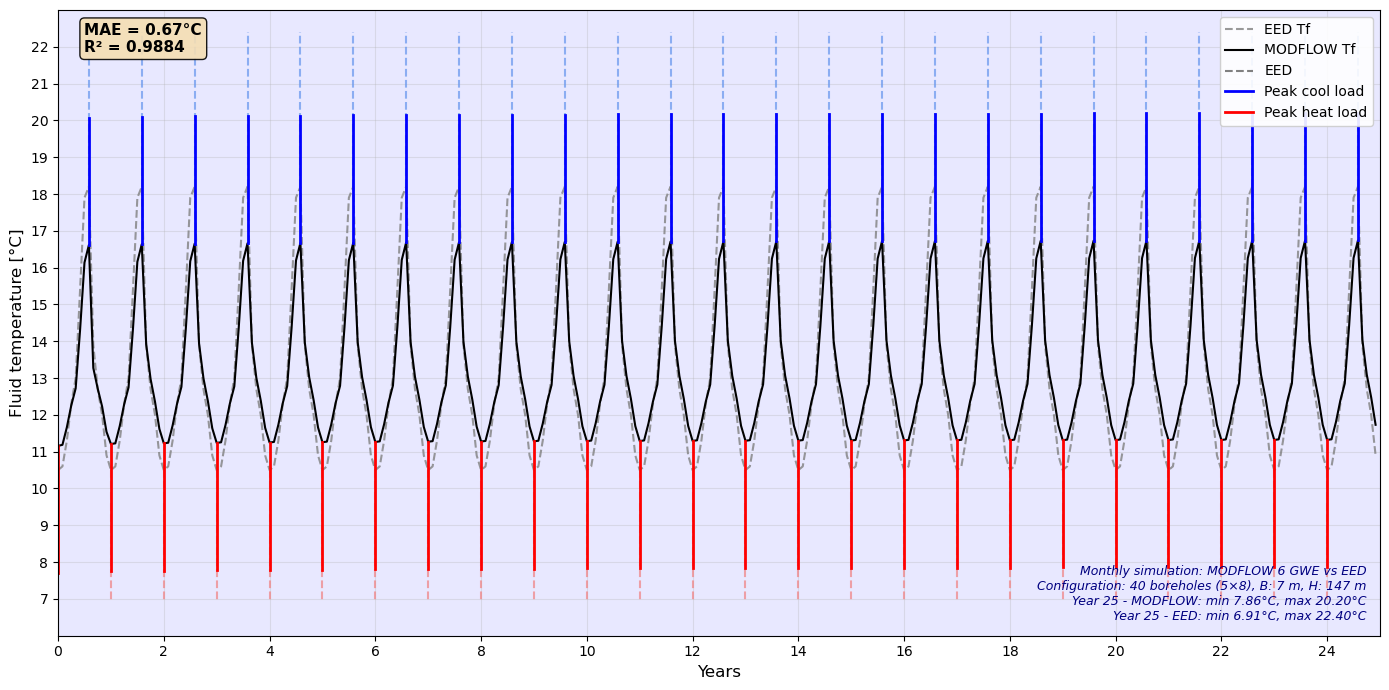


✓ Figure saved to figures/modflow_eed_comparison_25years.png

Error Statistics:
  MAE = 0.67°C
  R² = 0.9884

Year 25 Comparison:
  Peak Heat Min: MODFLOW=7.86°C, EED=6.91°C
  Peak Cool Max: MODFLOW=20.20°C, EED=22.40°C


In [14]:
# =====================================================
# EED-Style Chart - 25-Year Full Data with Comparison
# =====================================================

# Generate 25-year EED data
eed_25yr = np.tile(eed_base, n_yr)
eed_peak_heat = eed_25yr.copy()
eed_peak_cool = eed_25yr.copy()
for yr in range(n_yr):
    eed_peak_heat[yr * 12 + 0] = eed_peak_heat_jan
    eed_peak_cool[yr * 12 + 7] = eed_peak_cool_aug

# Reorder MODFLOW results to JAN-start
Tf_jan = np.zeros(n_mo)
for yr in range(n_yr):
    for m_new, m_old in enumerate(idx_map):
        Tf_jan[yr*12 + m_new] = Tf_modflow[yr*12 + m_old]

# Peak temperatures for MODFLOW
Tf_peak_heat = Tf_jan.copy()
Tf_peak_cool = Tf_jan.copy()
for yr in range(n_yr):
    Tf_peak_heat[yr * 12 + 0] -= delta_T_peak
    Tf_peak_cool[yr * 12 + 7] += delta_T_peak

# Statistics
mae_all = np.mean(np.abs(Tf_jan - eed_25yr))
r2_all = stats.linregress(eed_25yr, Tf_jan).rvalue**2

# X-axis: years
x_years = np.arange(n_mo) / 12.0

# === Plotting ===
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_facecolor('#e8e8ff')

# EED Base Load (gray dashed line)
ax.plot(x_years, eed_25yr, color='gray', ls='--', lw=1.5, alpha=0.8, label='EED Tf')

# MODFLOW Base Load (black solid line)
ax.plot(x_years, Tf_jan, 'k-', lw=1.5, label='MODFLOW Tf')

# EED Peak Cool (light blue dashed lines)
for yr in range(n_yr):
    aug_idx = yr * 12 + 7
    x_aug = x_years[aug_idx]
    ax.plot([x_aug, x_aug], [eed_25yr[aug_idx], eed_peak_cool[aug_idx]], 
            color='cornflowerblue', ls='--', lw=1.5, alpha=0.7)

# MODFLOW Peak Cool (blue solid lines)
for yr in range(n_yr):
    aug_idx = yr * 12 + 7
    x_aug = x_years[aug_idx]
    ax.plot([x_aug, x_aug], [Tf_jan[aug_idx], Tf_peak_cool[aug_idx]], 
            'b-', lw=2)

# EED Peak Heat (light red dashed lines)
for yr in range(n_yr):
    jan_idx = yr * 12 + 0
    x_jan = x_years[jan_idx]
    ax.plot([x_jan, x_jan], [eed_25yr[jan_idx], eed_peak_heat[jan_idx]], 
            color='lightcoral', ls='--', lw=1.5, alpha=0.7)

# MODFLOW Peak Heat (red solid lines)
for yr in range(n_yr):
    jan_idx = yr * 12 + 0
    x_jan = x_years[jan_idx]
    ax.plot([x_jan, x_jan], [Tf_jan[jan_idx], Tf_peak_heat[jan_idx]], 
            'r-', lw=2)

# Legend
ax.plot([], [], color='gray', ls='--', lw=1.5, label='EED')
ax.plot([], [], 'b-', lw=2, label='Peak cool load')
ax.plot([], [], 'r-', lw=2, label='Peak heat load')

ax.set_xlabel('Years', fontsize=12)
ax.set_ylabel('Fluid temperature [°C]', fontsize=12)
ax.set_xlim(0, 25)
ax.set_ylim(6, 23)
ax.set_xticks(range(0, 26, 2))
ax.set_yticks(range(7, 23))
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', framealpha=0.9)

# Error statistics (top-left corner)
stats_text = f"MAE = {mae_all:.2f}°C\nR² = {r2_all:.4f}"
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        fontsize=11, ha='left', va='top', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

# Info annotation (bottom-right corner)
info_text = (f"Monthly simulation: MODFLOW 6 GWE vs EED\n"
             f"Configuration: 40 boreholes (5×8), B: 7 m, H: 147 m\n"
             f"Year 25 - MODFLOW: min {Tf_peak_heat[-12:].min():.2f}°C, max {Tf_peak_cool[-12:].max():.2f}°C\n"
             f"Year 25 - EED: min {eed_peak_heat_jan:.2f}°C, max {eed_peak_cool_aug:.2f}°C")
ax.text(0.99, 0.02, info_text, transform=ax.transAxes, 
        fontsize=9, ha='right', va='bottom',
        fontstyle='italic', color='navy')

plt.tight_layout()
plt.savefig('figures/modflow_eed_comparison_25years.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Figure saved to figures/modflow_eed_comparison_25years.png")
print(f"\nError Statistics:")
print(f"  MAE = {mae_all:.2f}°C")
print(f"  R² = {r2_all:.4f}")
print(f"\nYear 25 Comparison:")
print(f"  Peak Heat Min: MODFLOW={Tf_peak_heat[-12:].min():.2f}°C, EED={eed_peak_heat_jan:.2f}°C")
print(f"  Peak Cool Max: MODFLOW={Tf_peak_cool[-12:].max():.2f}°C, EED={eed_peak_cool_aug:.2f}°C")